# Land Cover Classification using Deep Learning Techniques and EuroSAT

### CS294-82 Project
### Simona Aksman

## Mounting google drive for dataset access and saving models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [2]:
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
DATA_DIR = '.'

ds, ds_info = tfds.load('eurosat/all',
                        with_info=True,
                        split='train',
                        data_dir=DATA_DIR)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ./eurosat/all/2.0.0.incompleteTILBXS/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to ./eurosat/all/2.0.0. Subsequent calls will reuse this data.


In [4]:
ds_df = tfds.as_dataframe(ds, ds_info)

In [5]:
ds_df.head()

,filename,label,sentinel2
0,b'Highway_406.tif',3,"[[[1532.0, 1314.0, 1196.0, 1084.0, 1342.0, 174..."
1,b'Forest_2936.tif',1,"[[[1582.0, 1130.0, 804.0, 517.0, 684.0, 1487.0..."
2,b'Residential_586.tif',7,"[[[1315.0, 942.0, 863.0, 600.0, 821.0, 1743.0,..."
3,b'SeaLake_799.tif',9,"[[[1123.0, 808.0, 560.0, 329.0, 284.0, 255.0, ..."
4,b'Forest_1499.tif',1,"[[[1298.0, 975.0, 827.0, 521.0, 769.0, 1842.0,..."


## Config

In [ ]:
IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.2


## Utils

In [7]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [8]:

## Example for decoding and encoding
print(encode_label('Forest'), decode_target(2))
print(decode_target(2, text_labels=True))

1 HerbaceousVegetation
HerbaceousVegetation
1 HerbaceousVegetation
HerbaceousVegetation


## Processing data folders to train and test


In [9]:
DATA_DF = ds_df
DATA_DF['filename'].str.decode("utf-8")

0                      Highway_406.tif
1                      Forest_2936.tif
2                  Residential_586.tif
3                      SeaLake_799.tif
4                      Forest_1499.tif
                     ...              
26995                 Highway_1813.tif
26996               Industrial_764.tif
26997    HerbaceousVegetation_1014.tif
26998                  Forest_2459.tif
26999    HerbaceousVegetation_1615.tif
Name: filename, Length: 27000, dtype: object

In [10]:
TRAIN_DF, VALID_DF, TEST_DF = np.split(DATA_DF.sample(frac=1, random_state=42), [int(.8*len(DATA_DF)), int(.9*len(DATA_DF))])
TRAIN_DF.reset_index(inplace = True) 
VALID_DF.reset_index(inplace = True) 
TEST_DF.reset_index(inplace = True) 

## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [11]:
import torchvision.transforms as transforms

class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['filename'], decode_target(row['label'])
        img = transforms.ToPILImage()(row['image'])
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

class EuroSAT_threeBand(Dataset):
    def __init__(self, train_df, train_dir, channel_list, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        self.channel_list = channel_list
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        def min_max_norm(im):
          '''
          Normalizes an image's pixel intensity using min max normalization
          
          Parameters
          ----------
          im : array
          
          Returns
          -------
          im : array
          '''
          return (im - im.min()) / (im.max() - im.min())
        row = self.train_df.loc[idx]
        img_id, label = row['filename'], decode_target(row['label'])

        c1, c2, c3 = self.channel_list[0], self.channel_list[1], self.channel_list[2]

        b1 = row['sentinel2'][:,:,c1] 
        b2 = row['sentinel2'][:,:,c2] 
        b3 = row['sentinel2'][:,:,c3]
        img_array = (np.clip(np.dstack([min_max_norm(b1), min_max_norm(b2), min_max_norm(b3)]), 0, 1) * 255).astype(np.uint8)

        if self.transform:
            img = self.transform(img_array)
        return img, encode_label(label)

### Transformations and Datasets

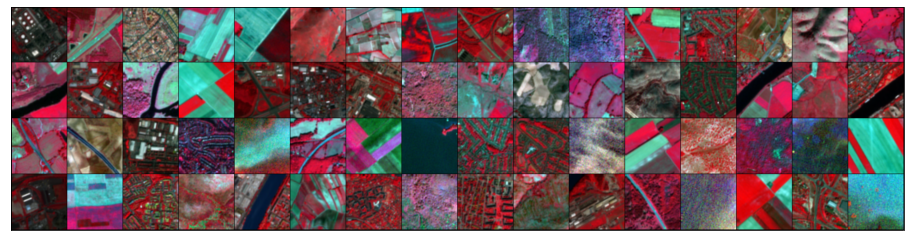

In [12]:
## Data loaders and showing batch of data

## Dataset and transformations
data_transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                ])
# CIR:
train_ds = EuroSAT_threeBand(TRAIN_DF, '.', [7, 3, 2], data_transform)
valid_ds = EuroSAT_threeBand(VALID_DF, '.', [7, 3, 2], data_transform)


batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

## Model

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
class GoogleNet(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [15]:
model = GoogleNet()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [16]:
## Running through the data loader => Model => Output
def try_batch(dl):
  for images, labels in dl:  
    print(images.shape)
    out = model(images)
    print(out.shape)
    print(out[0])
    break

try_batch(train_dl)

torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.3502, -2.2947, -2.3278, -2.3443, -2.4393, -2.1740, -2.3608, -2.3110,
        -2.0922, -2.3798], grad_fn=<SelectBackward0>)


## Training and Evaluating

In [17]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

## Initializing Device also Loading Data and Model to device¶


In [18]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [19]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(GoogleNet(), device)
## lets try passing a batch to model again
try_batch(train_dl)

True


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.3313, -2.8572, -2.5581, -2.2353, -2.0759, -2.5187, -2.1707, -2.1117,
        -2.2821, -2.1389], device='cuda:0', grad_fn=<SelectBackward0>)


In [20]:
torch.cuda.empty_cache()

## Training

In [21]:
## Hyper Parameters
max_epochs_stop = 15
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 15
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, valid_dl)

{'val_acc': 0.09859496355056763, 'val_loss': 2.309857130050659}

In [22]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.8805, learning_rate: 0.0001, train_loss: 0.4695, val_loss: 0.1065, val_acc: 0.9688


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9692, learning_rate: 0.0001, train_loss: 0.1044, val_loss: 0.0811, val_acc: 0.9744


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9828, learning_rate: 0.0001, train_loss: 0.0621, val_loss: 0.0792, val_acc: 0.9738


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9849, learning_rate: 0.0001, train_loss: 0.0474, val_loss: 0.0874, val_acc: 0.9738


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9896, learning_rate: 0.0001, train_loss: 0.0347, val_loss: 0.0804, val_acc: 0.9741


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9928, learning_rate: 0.0001, train_loss: 0.0269, val_loss: 0.0805, val_acc: 0.9753


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9925, learning_rate: 0.0000, train_loss: 0.0261, val_loss: 0.0954, val_acc: 0.9746


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9920, learning_rate: 0.0000, train_loss: 0.0274, val_loss: 0.0884, val_acc: 0.9767


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9917, learning_rate: 0.0000, train_loss: 0.0284, val_loss: 0.0966, val_acc: 0.9735


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9928, learning_rate: 0.0000, train_loss: 0.0249, val_loss: 0.0922, val_acc: 0.9753


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9931, learning_rate: 0.0000, train_loss: 0.0249, val_loss: 0.0928, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9917, learning_rate: 0.0000, train_loss: 0.0269, val_loss: 0.0850, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9914, learning_rate: 0.0000, train_loss: 0.0275, val_loss: 0.1001, val_acc: 0.9731


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9918, learning_rate: 0.0000, train_loss: 0.0270, val_loss: 0.0922, val_acc: 0.9742


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9926, learning_rate: 0.0000, train_loss: 0.0259, val_loss: 0.0876, val_acc: 0.9753
VAL LOSS MIN 0.07921851426362991
VAL ACC MAX 0.9767441749572754


## Reports

### Training Reports

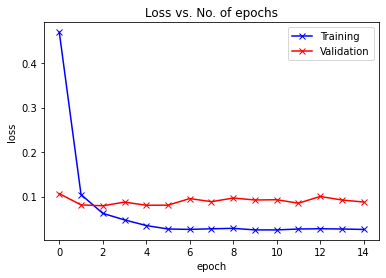

In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

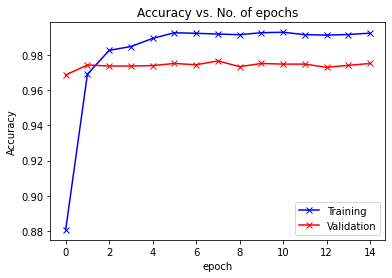

In [24]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

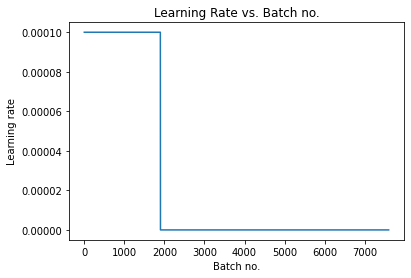

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

### Prediction Reports

In [ ]:
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

### Predict Single Images
def predict_single(image):
    show_sample(image)
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)


'Industrial'

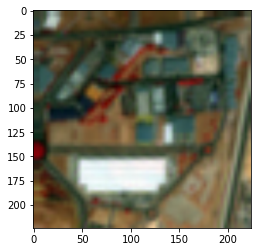

In [ ]:
predict_single(valid_ds[10][0])

'SeaLake'

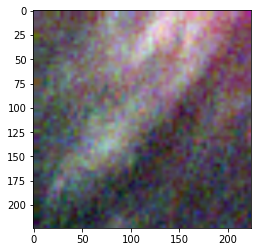

In [ ]:
predict_single(valid_ds[25][0])

'Residential'

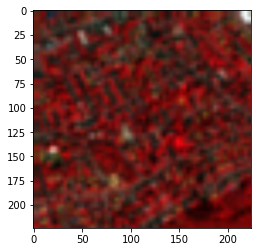

In [ ]:
predict_single(valid_ds[120][0])

## Evaluation on whole dataset and extract CNN layer per item

In [ ]:
batch_size = 1
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

In [ ]:
# Save off CNN layer per image
# https://colab.research.google.com/github/kozodoi/website/blob/master/_notebooks/2021-05-27-extracting-features.ipynb

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# Register hook
model.network.avgpool.register_forward_hook(get_features('avgpool'))

features = {}
batch_size = 1
@torch.no_grad()
def predict_extract_cnn_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, batch_cnns, labels = [], [], []

    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())    
        batch_cnns.append(features['avgpool'].cpu().numpy())
        labels.append(label.cpu().numpy())   
    return [x for x in batch_pred], [x for x in batch_cnns], [x for x in labels]

In [ ]:
## Accuracy Evaluation
def final_accuracy(predictions, labels):
  predictions = to_device(predictions, device)
  labels = to_device(labels, device)
  ## Total Accuracy
  total = 0
  for i in range(len(predictions)):
    if predictions[i] == labels[i]:
      total += 1
  acc = total/len(predictions)
  print(acc)

In [ ]:
full_ds = EuroSAT_threeBand(TRAIN_DF, '.', [7, 3, 2], data_transform)
full_dl = DataLoader(full_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
device = get_device()
## Loading data to devide
full_dl = DeviceDataLoader(full_dl, device)


True


In [ ]:
predictions, cnns, labels = predict_extract_cnn_dl(full_dl, model)

  0%|          | 0/24300 [00:00<?, ?it/s]

In [ ]:
cnns_flattened = [x.flatten() for x in cnns]
cnns_df = pd.DataFrame({'googlenet_avgpool_layer': cnns_flattened, 'label': labels})

# Calculate data MEC

In [ ]:
def calculate_mec(data, labels):
	'''
	Calculate MEC needed for a classifier assuming weight
	equilibrium (no gradient descent). 
	Requires: data array of length n  which contains d-dim vectors 
	x, and a label column of length n.

	Parameters
  ----------
  data : array
    
  Returns
  -------
  mec : float

	'''
	assert len(data) == len(labels)

	# d = num dimensions in data
	d = data[0].shape[0]

	thresholds = 0
	table = []
	for i in range(len(data)):
	  # Sum up all data in the row and append the label
	  table.append([data[i].sum(), labels[i]])
	# Sort by sum in reverse order
	sortedtable = sorted(table, key=lambda x: x[0], reverse=True)

	# Iterate through sorted table and compute thresholds
	# by comparing class labels for each row and the prior row
	# Initialize with first class label in list
	class_label = sortedtable[0][1]
	for i in range(len(sortedtable)):
	  if not sortedtable[i][1] == class_label:
	    thresholds = thresholds + 1 
	    class_label = sortedtable[i][1]

	mec = math.log2(thresholds + 1) * d
	return mec

def get_sample(p, data, labels, seed):
	'''
	Return p percent of the data with corresponding labels.

	Parameters
	----------
	p : float in range [0, 1]
	data : array
	labels : array
    seed  : int

  Returns
  -------
  data, labels : array, array

	'''
	num_labels = len(labels)
	size = int(p * num_labels)

	np.random.seed(seed)
	np.random.shuffle(data)
	np.random.shuffle(labels)
	
	return data[:size], labels[:size] 


# Algorithm 2 
def calculate_capacity_progression(data, labels):
	'''
	Calculate capacity progression for the Equilibrium Machine Learner.
	Requires: data array of length n  which contains d-dim vectors 
	x, and a binary label column of length n.

	Parameters
  ----------
  data : array
  labels : array
    
  Returns
  -------
  capacities : dictionary

	'''
	sizes = [.05, .1, .2, .4, .8, 1]
	capacities = {}
	for size in sizes:
		sample_data, sample_labels = get_sample(size, data, labels, 1234)
		mec = calculate_mec(sample_data, sample_labels)
		capacities[size * 100] = mec
		
		print("MEC for " + str(int(size * 100)) + " percent of the data: " + str(round(mec, 2)) + " bits")

	return capacities	

In [ ]:
# Calculate MEC for training dataset
calculate_mec(cnns_df['googlenet_avgpool_layer'], cnns_df['label'])

14604.009127225263

# Capacity progression

In [ ]:
capacities = calculate_capacity_progression(cnns_df['googlenet_avgpool_layer'], cnns_df['label'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MEC for 5 percent of the data: 10156.92 bits
MEC for 10 percent of the data: 11183.97 bits
MEC for 20 percent of the data: 12237.0 bits
MEC for 40 percent of the data: 13245.8 bits
MEC for 80 percent of the data: 14277.89 bits
MEC for 100 percent of the data: 14604.01 bits


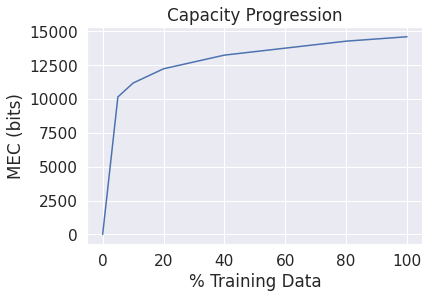

In [ ]:
capacities.update({0: 0})

lists = sorted(capacities.items()) # sorted by key, return a list of tuples

# Add title and axis names

plt.clf()
x, y = zip(*lists) # unpack a list of pairs into two tuples
# plt.ylim(0, 100)
plt.plot(x, y)
# plt.legend(loc='lower right')
plt.title('Capacity Progression')
plt.xlabel('% Training Data')
plt.ylabel('MEC (bits)')
plt.show()